In [1]:
# Importamos las librerías necesarias y fijamos la semilla.
import numpy as np
import random
import scipy
from scipy.stats import uniform as spuniform
import matplotlib.pyplot as plt

from matplotlib import pyplot
import math
import statistics
import pandas as pd
import time
!pip install networkx
import networkx as nx

from matplotlib import colors

np.random.seed(11)

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Calcula cuánto tiempo ha pasado desde un momento dado hasta el momento actual.
def timeSince(since):
    now = time.time_ns()
    s = now - since
    return s*10**(-9)

Definimos la función grafoM que crea un mapa con la estructura de regiones con provincias a partir de una lista P que informe el número de provincias por región:

In [3]:
def grafoM(P):
    # Inicialización del grafo dirigido.
    G = nx.DiGraph()
    # Suma de cantidad de provincias por región.
    V = sum(P[i] for i in range(len(P)))
    # Agregamos los vértices de un grafo.
    G.add_nodes_from(range(V))
    R = {}
    # Generación de posiciones para cada provincia.
    # Se itera sobre cada región.
    for i in range(len(P)):
        pi = []
        # Se itera sobre cada provincia.
        for p in range(P[i]):
            # Crea una tupla (x,y) posición de la provincia.
            pi.append(np.array([np.random.uniform(), i + np.random.uniform()]))
        R[i] = pi
    C = {}
    # Calculando el costo de las aristas.
    for r in R:
        if r < len(R)-1:
            # Definimos el costo de cada arista.
            C[r]= {}
            for j in range(len(R[r])): 
                C[r][j]= []
                for k in range(len(R[r+1])):
                    # Costo definido como distancia euclideana.
                    C[r][j].append(np.linalg.norm(R[r][j] - R[r+1][k])) 
    # Creación de las aristas del grafo.
    E = []
    k=0
    for i in range(len(P)-1):
        for j in range(P[i]):
            for h in range(P[i+1]):
                E.append((k+j,k+P[i]+h, {"weight": C[i][j][h]} ))
        k+=P[i]
    G.add_edges_from(E)        
    return G , R , C

In [4]:
# Se define el costo de una ruta como la suma de los costos de cada arista.
def costo(ruta, distancias):
    S = 0
    for i in range(len(ruta)-1):
        # Donde estoy.
        inicio = ruta[i][1]
        # Donde voy.
        fin = ruta[i+1][1]
        # Sumo costo.
        S += distancias[i][inicio][fin]
    return S

Aplicamos Simulated Annealing. Para esto se requiere:

- mapa: un grafo creado con la función grafo.
- distancias: costos asociados a las aristas del grafo anterior.
- $\sigma_0$: configuración (ruta) inicial.
- C: ponderador aplicado a la función $\beta$.
- beta: función beta para crear sucesión $\beta_n$.


In [5]:
# Parámetros a cambiar.
# Cantidad de pasos
pasos=10**4

In [6]:
def SimAnn(mapa, distancias, sigma0, C, beta, pasos):
    # Se definen las uniformes para cada paso.
    U = np.random.uniform(size = pasos)
    # Almacenamos las configuraciones.
    sigmas = [sigma0]
    # Almacenamos los costos de cada iteración.
    w = [costo(sigma0,distancias)]
    conteo=0
    for i in range(pasos-1):
        # Configuración anterior.
        sigma = sigmas[i]
        # Definimos beta_n según la función dada.
        betan = beta(i,C)
        # Definimos el vecino.
        # En qué región cambiar.
        region = np.random.randint(1,len(mapa)-1)
        # Provincias de la region menos la tomada.
        provincias = [i for i in range(len(mapa[region])) if i != sigma[region][1]]
        # Elijo a qué provincia cambiar.
        prov = np.random.choice(provincias)
        # Construimos el vecino.
        tau = [sigma[0]]
        for j in range(1,len(sigma)):
            # Estoy en la región de cambio.
            if j == region:
                tau.append((j,prov))
            else:
                tau.append(sigma[j])
        # Costo anterior.
        ws = costo(sigma,distancias)
        # Costo vecino.
        wt = costo(tau,distancias)
        dif = np.exp(-betan*(wt-ws))
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(costo(tau,distancias))
        else:
            sigmas.append(sigma)
            w.append(costo(sigma,distancias))
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas

Hacemos la prueba sobre un mismo grafo, cambiando la sucesión de $\beta_n$ y los parámetros C y los pasos del Simmulated Annealing:

In [7]:
# Parámetros a cambiar.
# Beta lineal.
def beta1(n,C):
    return n/C

# Beta cuadrático.
def beta2(n,C):
    return (n**2)/C

# Beta exponencial.
def beta3(n,C):
    return np.exp(n)/C

In [8]:
# Transforma el formato de una ruta u,v,y a (0,u),(1,v),(2,y).
def camino(ruta,ciudad):
    A=[]
    k=0
    for i in range(len(ruta)):
        A.append((i,ruta[i]-k))
        k+= len(ciudad[i])
    return A

Definimos una función que dibuja una ruta en la grilla del país. Para esto se le entrega:

- $\sigma$: una ruta del mapa.
- ciudades: el mapa de las ciudades.

También se puede entregar de manera opcional:

- p: otra ruta del mapa para comparar con $\sigma$.
- index: lista de índices de $\sigma$ que se desean destacar.

In [9]:
# Sigma una configuración como secuencia de vértices.
def plotear(sigma,ciudades,p=[],index=[]):
    plt.figure()
    # Graficar provincias.
    X= [ciudades[i][j][0] for i in range(len(ciudades)) for j in range(len(ciudades[i]))]
    Y= [ciudades[i][j][1] for i in range(len(ciudades)) for j in range(len(ciudades[i]))]
    plt.scatter(X,Y, marker="o")
    plt.scatter(X[0],Y[0],marker="x", color="g")
    plt.scatter(X[-1],Y[-1],marker="x", color="g")
    for i in range(len(R)):
        plt.axhline(y = i, color = 'b', linestyle = '-')
    for i in range(len(sigma)-1):
        plt.plot([ciudades[sigma[i][0]][sigma[i][1]][0],ciudades[sigma[i+1][0]][sigma[i+1][1]][0]],[ciudades[sigma[i][0]][sigma[i][1]][1],ciudades[sigma[i+1][0]][sigma[i+1][1]][1]],'k-')
    if len(index)>0:
        for i in index:
            plt.plot([ciudades[sigma[i][0]][sigma[i][1]][0],ciudades[sigma[i+1][0]][sigma[i+1][1]][0]],[ciudades[sigma[i][0]][sigma[i][1]][1],ciudades[sigma[i+1][0]][sigma[i+1][1]][1]],'k-',color="r")
    for i in range(len(p)-1):
        plt.plot([ciudades[p[i][0]][p[i][1]][0],ciudades[p[i+1][0]][p[i+1][1]][0]],[ciudades[p[i][0]][p[i][1]][1],ciudades[p[i+1][0]][p[i+1][1]][1]],'k-',color= "g")

## Simulación de evaluación

Comenzamos creando un grafo cualquiera.

In [10]:
# Parámetros a cambiar.
# Lista del número de provincias por región.
P = [2,2,3,3,3,8,6,3,4,3,3,2,2,4,4,4]

G,R,C = grafoM(P)

# Encontremos de inmediato el camino más corto desde el nodo 0 al último nodo:
p = nx.shortest_path(G,0,len(G.nodes)-1,"weight")
p = camino(p,R)

# Procedamos a realizar el S.A., primero definimos los parámetros:

# Parámetros a cambiar.
c = [1,5,10,100]
pasos = [10**2, 10**3, 10**4]

# Luego creamos una ruta aleatoria para comenzar:

ruta = [(0,0)]
for i in range(1,len(R)-1):
    ruta.append((i,np.random.randint(0,len(R[i]))))
ruta.append((len(R)-1,len(R[len(R)-1])-1))

# Se realizan distintas iteraciones de S.A. según cada parámetro:

# Parámetros a cambiar.
# beta = beta1, beta2, beta3 (lineal, cuadrática, exponencial).
beta = beta1
# c = c[0], c[1], c[2], c[3] (1, 5, 10, 100).
c = c[0]
# i = 0, 1, 2 (100, 1.000, 10.000)
i=2

s10,w10,W10,S10 = SimAnn(R,C,ruta,c,beta,pasos[i])

### Evaluación de Simulaciones

Veamos la evolución de la función de energía (distancia total de la ruta) para cada método según el parámetro C.

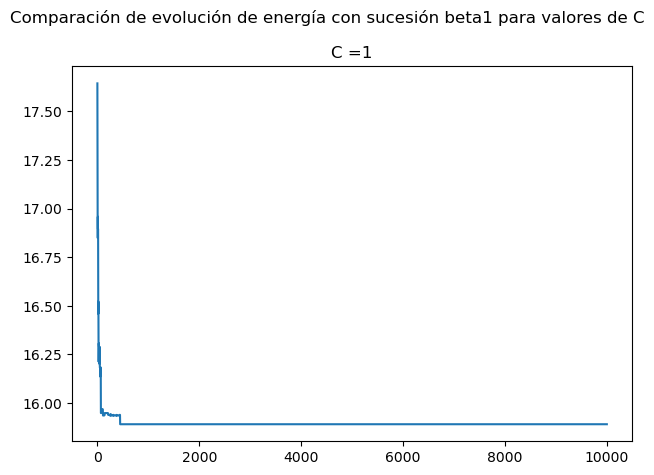

In [11]:
X = range(pasos[i])
fig, axs = plt.subplots(1, 1)
axs.plot(X, W10)
axs.set_title('C =' + str(c))
fig.suptitle("Comparación de evolución de energía con sucesión "+beta.__name__+" para valores de C")
fig.tight_layout()

Evaluamos los costos de cada camino encontrado al final del Annealing, comparando con el óptimo original encontrado con Dijkstra:

In [12]:
d = {"Método": [beta.__name__] , "C="+str(c): [costo(s10,C)], "Dijkstra": [costo(p,C)]}
df = pd.DataFrame(d)
df

,Método,C=1,Dijkstra
0,beta1,15.889633,15.838588


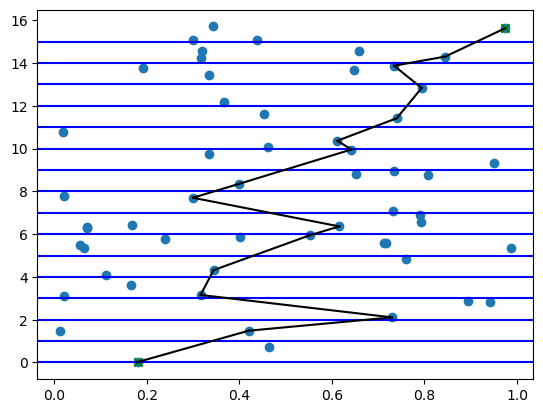

In [13]:
plotear(s10,R)